In [1]:
import cudf
import pandas as pd
import numpy as np
import time
from io import BytesIO
import os
import timeit

In [2]:
np.random.seed(0)

In [3]:
pdf = pd.DataFrame({
    "numbers": np.random.randint(-1000, 1000, 30_000_0000, dtype='int64'),
    "business": np.random.choice(["McD", "Buckees", "Walmart", "Costco"], size=30_000_0000)
})

In [4]:
pdf

,numbers,business
0,-316,Costco
1,-441,Costco
2,653,Buckees
3,216,Buckees
4,-165,Walmart
...,...,...
299999995,-395,Walmart
299999996,-653,Buckees
299999997,364,Buckees
299999998,159,Buckees


In [5]:
gdf = cudf.from_pandas(pdf)

In [6]:
gdf

,numbers,business
0,-316,Costco
1,-441,Costco
2,653,Buckees
3,216,Buckees
4,-165,Walmart
...,...,...
299999995,-395,Walmart
299999996,-653,Buckees
299999997,364,Buckees
299999998,159,Buckees


In [8]:
pandas_pq = BytesIO()

In [9]:
pandas_to_parquet = timeit.timeit(lambda : pdf.to_parquet(pandas_pq), number=10)

In [10]:
cudf_pq = BytesIO()

In [11]:
cudf_to_parquet = timeit.timeit(lambda : gdf.to_parquet(cudf_pq), number=10)

In [12]:
os.system("/sbin/sysctl vm.drop_caches=3")
pandas_read_parquet = timeit.timeit(lambda : pd.read_parquet(pandas_pq), number=10)

sysctl: setting key "vm.drop_caches", ignoring: Read-only file system


In [13]:
os.system("/sbin/sysctl vm.drop_caches=3")
cudf_read_parquet = timeit.timeit(lambda : cudf.read_parquet(cudf_pq), number=10)

sysctl: setting key "vm.drop_caches", ignoring: Read-only file system


In [14]:
pandas_csv = BytesIO()
cudf_csv = BytesIO()
pdf = pdf.head(10_000_0000)
gdf = gdf.head(10_000_0000)

In [15]:
def to_csv_bench(df):
    file_obj = BytesIO()
    df.to_csv(file_obj)

In [16]:
pandas_to_csv = timeit.timeit(lambda : to_csv_bench(pdf), number=2)

In [17]:
cudf_to_csv = timeit.timeit(lambda : to_csv_bench(gdf), number=1)

In [19]:
pandas_csv = BytesIO()
cudf_csv = BytesIO()
pdf.to_csv(pandas_csv)
gdf.to_csv(cudf_csv)

In [22]:
def read_csv_bench(pkg, file_obj):
    file_obj.seek(0)
    pkg.read_csv(file_obj)

In [23]:
os.system("/sbin/sysctl vm.drop_caches=3")
pandas_read_csv = timeit.timeit(lambda : read_csv_bench(pd, pandas_csv), number=10)

sysctl: setting key "vm.drop_caches", ignoring: Read-only file system


In [24]:
os.system("/sbin/sysctl vm.drop_caches=3")
cudf_read_csv = timeit.timeit(lambda : read_csv_bench(cudf, cudf_csv), number=10)

sysctl: setting key "vm.drop_caches", ignoring: Read-only file system


In [25]:
pandas_groupby = timeit.timeit(lambda : pdf.groupby("business").agg(["min", "max", "mean"]), number=10)

In [26]:
cudf_groupby = timeit.timeit(lambda : gdf.groupby("business").agg(["min", "max", "mean"]), number=10)

In [27]:
# TODO : Remove this memory limitation(from pandas side) slicing 
pdf = pd.DataFrame({
    "numbers": np.random.randint(-1000, 1000, 1_000_000, dtype='int64'),
    "business": np.random.choice(["McD", "Buckees", "Walmart", "Costco"], size=1_000_000)
})
gdf = cudf.from_pandas(pdf)

In [28]:
pandas_merge = timeit.timeit(lambda : pdf.merge(pdf), number=10)

In [29]:
cudf_merge = timeit.timeit(lambda : gdf.merge(gdf), number=10)

In [30]:
import matplotlib.pyplot as plt

In [31]:
perf_df = pd.DataFrame(
    {
        "cudf speed up v/s pandas": [pandas_to_parquet/cudf_to_parquet, pandas_read_parquet/cudf_read_parquet, pandas_to_csv/cudf_to_csv, pandas_read_csv/cudf_read_csv, pandas_groupby/cudf_groupby, pandas_merge/cudf_merge],
}, index=["to_parquet", "read_parquet", "to_csv", "read_csv", "groupby", "merge"])

In [32]:
perf_df

,cudf speed up v/s pandas
to_parquet,17.713185
read_parquet,48.988675
to_csv,113.220413
read_csv,21.481295
groupby,103.912005
merge,108.223942


[Text(0, 0, '17.7132'),
 Text(0, 0, '48.9887'),
 Text(0, 0, '113.22'),
 Text(0, 0, '21.4813'),
 Text(0, 0, '103.912'),
 Text(0, 0, '108.224')]

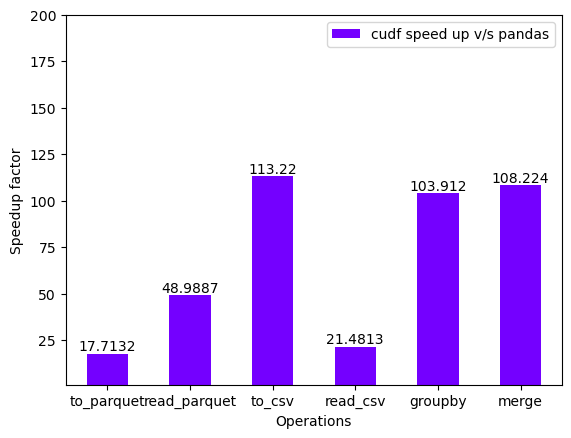

In [33]:
ax = perf_df.plot.bar(color='#7400ff', ylim=(1,200), rot=0)
ax.set_xlabel("Operations")
ax.set_ylabel("Speedup factor")
ax.bar_label(ax.containers[0])

In [34]:
pd_series = pd.Series(np.random.choice(["123", "56.234", "Walmart", "Costco", "rapids ai"], size=10_000_0000))

In [35]:
gd_series = cudf.from_pandas(pd_series)

In [36]:
pandas_upper = timeit.timeit(lambda : pd_series.str.upper(), number=10)

In [37]:
cudf_upper = timeit.timeit(lambda : gd_series.str.upper(), number=10)

In [38]:
pandas_contains = timeit.timeit(lambda : pd_series.str.contains(r"[0-9][a-z]"), number=10)

In [39]:
cudf_contains = timeit.timeit(lambda : gd_series.str.contains(r"[0-9][a-z]"), number=10)

In [40]:
pandas_isalpha = timeit.timeit(lambda : pd_series.str.isalpha(), number=10)

In [41]:
cudf_isalpha = timeit.timeit(lambda : gd_series.str.isalpha(), number=10)

In [42]:
perf_df = pd.DataFrame(
    {
        "cudf speed up v/s pandas": [pandas_upper/cudf_upper, pandas_contains/cudf_contains, pandas_isalpha/cudf_isalpha,],
}, index=["upper", "contains", "is_alpha",])

[Text(0, 0, '1533.03'), Text(0, 0, '705.921'), Text(0, 0, '1311.85')]

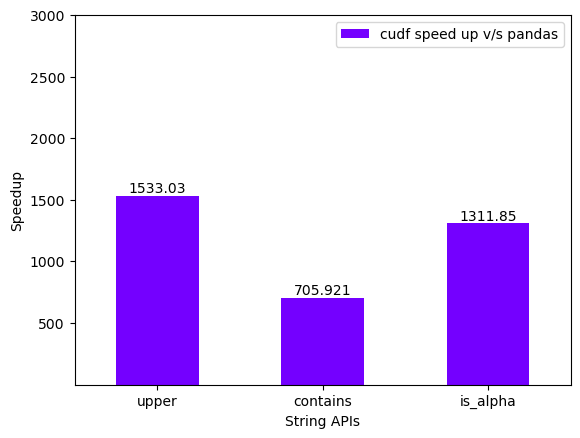

In [43]:
ax = perf_df.plot.bar(color='#7400ff', ylim=(1,3000), rot=0)
ax.set_xlabel("String APIs")
ax.set_ylabel("Speedup")
ax.bar_label(ax.containers[0])

## UDF

In [3]:
size = 10000000
pdf = pd.DataFrame({
    'age': np.random.randint(0,100,size),
})

In [4]:
def f(row):
    if row['age'] < 18:
        return 0
    elif 18 <= row['age'] < 20:
        return 1
    elif 20 <= row['age'] < 30:
        return 2
    elif 30 <= row['age'] < 40:
        return 3
    elif 40 <= row['age'] < 50:
        return 4
    elif 50 <= row['age'] < 60:
        return 5
    elif 60 <= row['age'] < 70:
        return 6
    else:
        return 7

In [5]:
gdf = cudf.from_pandas(pdf)

In [6]:
pandas_int_udf = timeit.timeit(lambda : pdf.apply(f, axis=1), number=10)

In [7]:
cudf_int_udf = timeit.timeit(lambda : gdf.apply(f, axis=1), number=10)

In [13]:
def str_func(row):
    if row['strings'].isupper():
        return 0
    else:
        return 1

In [10]:
pd_series = pd.Series(np.random.choice(["ABC", "abc", "hello world", "AI"], size=10_000_000), name='strings').to_frame()

In [11]:
gd_series = cudf.from_pandas(pd_series)

In [14]:
pandas_str_udf = timeit.timeit(lambda : pd_series.apply(str_func, axis=1), number=10)

In [15]:
cudf_str_udf = timeit.timeit(lambda : gd_series.apply(str_func, axis=1), number=10)

In [ ]:
size = 100000000
pdf = pd.DataFrame()
pdf['key'] = np.random.randint(0,2,size)
pdf['val'] = np.random.randint(0,7,size)


def mult(df):
  df['out'] = df['key'] * df['val'] - 10
  return df


gdf = cudf.from_pandas(pdf)

In [17]:
pandas_udf_groupby = timeit.timeit(lambda : pdf.groupby(['key']).apply(mult), number=10)

/tmp/ipykernel_47438/1960370463.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pandas_udf_groupby = timeit.timeit(lambda : pdf.groupby(['key']).apply(mult), number=10)
/tmp/ipykernel_47438/1960370463.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  pandas_udf_groupby = timeit.timeit(lamb

In [18]:
cudf_udf_groupby = timeit.timeit(lambda : gdf.groupby(['key']).apply(mult), number=10)

In [19]:
perf_df = pd.DataFrame(
    {
    "cudf speed up v/s pandas": [pandas_int_udf/cudf_int_udf, 
                                 pandas_str_udf/cudf_str_udf,
                                 pandas_udf_groupby/cudf_udf_groupby],
}, index=["int_udf", 
          "str_udf",
          "groupby_udf"])

[Text(0, 0, '700.995'), Text(0, 0, '26.9024'), Text(0, 0, '307.897')]

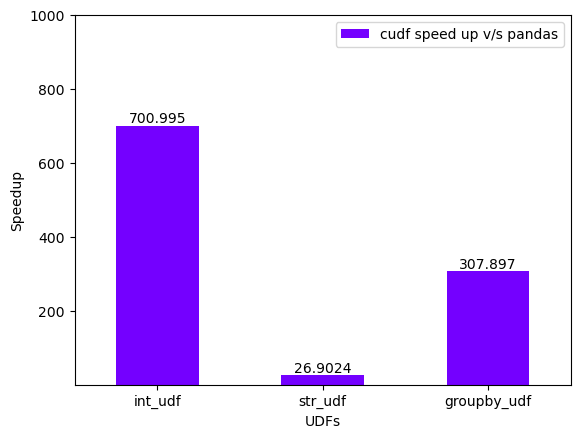

In [22]:
ax = perf_df.plot.bar(color='#7400ff', ylim=(1,1000), rot=0)
ax.set_xlabel("UDFs")
ax.set_ylabel("Speedup")
ax.bar_label(ax.containers[0])